## <font color="Red">要検討事項</font>
1. 3ヶ月先・6ヶ月先で予測したら結果はどう変わるか？

2. モデルの復元（重みは保存してある）

3. RMSEは各ラベルとの誤差を足し合わせたものを最小化で合ってる？

4. こっちは正規化・PCAは標準化（適用するデータは訓練のみ？）

5. 短期国債の利回りは変わらなさそ→長期国債の利回りについての差が開いた？

6. matplotlibのグラフをpng化することを忘れない。

7. LSTMに12期前から入力する意味は？

8. 出力層の活性化関数の検討余地は？ (ReLuでもないしsigmoidでもなさそう・少し0より小さい値返すやつならいけるか？）→負の値はどんな感じ？→使えそうw

9. 訓練データ - validation_data , test_data にするべきか？


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

np.random.seed(50)
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [5]:
#データの読み込み
Macro = pd.read_csv('drive/My Drive/Mita_thesis/mita_thesis/Macro_ecn.csv' , index_col=0)
Yield = pd.read_csv('drive/My Drive/Mita_thesis/mita_thesis/bond_yield_add.csv' , index_col=0)
#ここもしかしたらいらないかも？
Macro.index = pd.date_range('1980-1-1', periods=Macro.shape[0], freq='M')
Yield.index = pd.date_range('1980-1-1', periods=Yield.shape[0],freq='M')

In [6]:
Macro=Macro.drop('SPR_1TNFF',axis=1)
Macro['SPR_2TNFF']=Yield['FF']-Yield['2Y']
Macro['SPR_20TNFF']=Yield['FF']-Yield['20Y']

In [7]:
Macro=Macro.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,19,20,22]]
Macro.columns

Index(['R_PCE', 'R_DPI', 'SR', 'HUS', 'IPI_M', 'CUR_M', 'ISM_M', 'MIC_I',
       'MIC_E', 'T_PCEIX', 'C_PCEIX', 'C_CPI', 'C_CPI_INF', 'NFE', 'UR', 'MB',
       'M2', 'R_EFCR', 'SP500', 'SPR_2TNFF', 'SPR_5TNFF', 'SPR_10TNFF',
       'SPR_20TNFF'],
      dtype='object')

In [8]:
print(Macro.shape[0],Yield.shape[0])

483 483


### 前処理
・7:3に分ける

・正規化（値の範囲を0~1）（PCAは標準化）

・windowsizeを1年周期にする

→つまり1年前までを入力とし、1期先を予測するデータセットにする。

##### 検討事項：3期先・6期先はどうか？

https://akenkenken.hatenablog.com/entry/2019/09/29/205040

In [9]:
bYield=Yield.iloc[:,2:]
Data=pd.concat([Macro,bYield],axis=1)

In [10]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset.iloc[i:i+look_back, j]
            xset.append(a)
        dataY.append(dataset.iloc[i+look_back, [23,24,25,26]])      
        dataX.append(xset)
    return np.array(dataX), np.array(dataY)

In [11]:
#datasetの作成と正規化の処理
datasplits=int((len(Macro))*0.72)
Data_train=Data[:datasplits]
Data_test=Data[datasplits:int((len(Macro))*0.93)]
Data_outsample=Data[int((len(Macro))*0.93):]
print(Data_train.shape,Data_test.shape,Data_outsample.shape)

#datasplits=int((len(Macro))*0.7)
#Data_train=Data[:datasplits]
#Data_test=Data[datasplits:]
#Data_outsample=Data[int((len(Macro))*0.93):]
#print(Data_train.shape,Data_test.shape)


#正規化
#訓練データのものを使う
Data_train_mm=(Data_train-Data_train.min())/(Data_train.max()-Data_train.min())
Data_test_mm=(Data_test-Data_train.min())/(Data_train.max()-Data_train.min())
Data_sample_mm=(Data_outsample-Data_train.min())/(Data_train.max()-Data_train.min())

(347, 27) (102, 27) (34, 27)


In [ ]:
#Data_train.min().values

In [12]:
#datasetの確認
X_train,y_train=create_dataset(Data_train_mm,12)
X_test,y_test=create_dataset(Data_test_mm,12)
X_out,y_out=create_dataset(Data_sample_mm,12)

In [13]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_out.shape,y_out.shape)
#これ不連続な点ができてないか?

(334, 27, 12) (334, 4) (89, 27, 12) (89, 4) (21, 27, 12) (21, 4)


In [14]:
#0からmax-1個
#不連続なデータの解消
Data_mm=(Data-Data_train.min())/(Data_train.max()-Data_train.min())
X,y=create_dataset(Data_mm,12)

X_ntest=np.concatenate((X[334:347],X_test),axis=0) #X[315:328] #訓練データの始まりの数
y_ntest=np.concatenate((y[334:347],y_test),axis=0)

X_nout=np.concatenate((X[436:449],X_out),axis=0) #X[436:449] #436=328+108(検証用データ) #間隔は指定した数+1
y_nout=np.concatenate((y[436:449],y_out),axis=0)

In [15]:
print(X_ntest.shape,y_ntest.shape,X_nout.shape,y_nout.shape)

(102, 27, 12) (102, 4) (34, 27, 12) (34, 4)


In [ ]:
#12期前から1期先を学習できているかの確認
#できている
#X_train[0],y_train[0]
#Data_train_mm.head(13)

In [ ]:
#正規化の確認
#X_train[0]

### LSTM及びDNNのモデル

・マルチタスク（複数出力）

・誤差関数の適用（RMSE-平均二乗誤差のルート)

・最適化関数

→Adam,Rmsoop

・活性化関数はLinear

多変量時系列

1.　<https://qiita.com/tizuo/items/b9af70e8cdc7fb69397f>

2.　<https://torch.classcat.com/2018/06/29/keras-ex-tutorials-lstm-time-series-prediction/>

In [16]:
#Kerasで行う。
from keras import backend as K
from keras.models import Sequential,Model,Input
from keras.layers import Dense,Embedding,Activation,LSTM,Dropout
from keras.optimizers import Adam,RMSprop
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
#平均二乗誤差
def root_mean_squared_error(y_true, y_pred): 
     return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

#### マクロ経済変数+過去の利回り 1年分 でLSTM
#### 半年前も試す

In [17]:
#LSTMの入力になるように形状変換をする。
X_train=X_train.reshape(X_train.shape[0],X_train.shape[2],X_train.shape[1])
X_test=X_test.reshape(X_test.shape[0],X_test.shape[2],X_test.shape[1])
X_out=X_out.reshape(X_out.shape[0],X_out.shape[2],X_out.shape[1])

X_ntest=X_ntest.reshape(X_ntest.shape[0],X_ntest.shape[2],X_ntest.shape[1])
X_nout=X_nout.reshape(X_nout.shape[0],X_nout.shape[2],X_nout.shape[1])

In [ ]:
#平均2乗誤差のルート
#def root_mean_squared_error(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [18]:
def plot_history_loss(hist):
    # 損失値(Loss)の遷移のプロット
    fig = plt.figure(facecolor='y')
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

In [19]:
#LSTM
hidden_size=250

#inp=Input(shape=(X_train.shape[1],X_train.shape[2]))
inp=Input(shape=(None,X_train.shape[2]))
lstm=LSTM(units=hidden_size,recurrent_dropout=0.2)(inp)
drop=Dropout(0.2)(lstm)
#out=Dense(4,activation='linear')(lstm)
out=Dense(4,activation='linear')(drop)

modellstm=Model(inputs=inp,outputs=out)

#modellstm.compile(optimizer='adam', loss=root_mean_squared_error,metrics=['mse'])
modellstm.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mse'])
modellstm.summary()
#loss_weights=[0.3,0.3,0.3,0.1]

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 27)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 250)               278000    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 1004      
Total params: 279,004
Trainable params: 279,004
Non-trainable params: 0
_________________________________________________________________


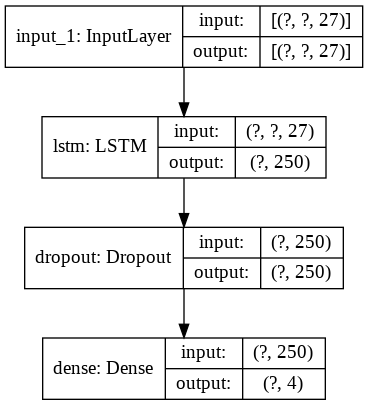

In [20]:
from keras.utils import plot_model
plot_model(modellstm,show_shapes=True,to_file='LSTMmodel.png')
#plot_model(modellstm1,show_shapes=True,to_file='LSTMmodel1.png')

In [ ]:
mc = ModelCheckpoint(filepath='lstmYield_Macro.hdf5', monitor='val_loss', 
                     verbose=1, save_best_only=True, mode='min')
#fpath = save_path + '/weights.{epoch:03d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5'
#model_ckp = ModelCheckpoint(filepath = fpath, monitor='loss', verbose=1, save_best_only=True, mode='auto', period=5)

In [ ]:
n_epoch=40
batch_size=15
history1=modellstm.fit(X_train,y_train,callbacks=mc,epochs=n_epoch,validation_data=(X_ntest,y_ntest),verbose=0,batch_size=batch_size)


Epoch 00001: val_loss improved from inf to 0.04919, saving model to lstmYield_Macro.hdf5

Epoch 00002: val_loss did not improve from 0.04919

Epoch 00003: val_loss did not improve from 0.04919

Epoch 00004: val_loss improved from 0.04919 to 0.04053, saving model to lstmYield_Macro.hdf5

Epoch 00005: val_loss improved from 0.04053 to 0.03942, saving model to lstmYield_Macro.hdf5

Epoch 00006: val_loss did not improve from 0.03942

Epoch 00007: val_loss improved from 0.03942 to 0.03343, saving model to lstmYield_Macro.hdf5

Epoch 00008: val_loss did not improve from 0.03343

Epoch 00009: val_loss improved from 0.03343 to 0.02795, saving model to lstmYield_Macro.hdf5

Epoch 00010: val_loss improved from 0.02795 to 0.02700, saving model to lstmYield_Macro.hdf5

Epoch 00011: val_loss did not improve from 0.02700

Epoch 00012: val_loss did not improve from 0.02700

Epoch 00013: val_loss did not improve from 0.02700

Epoch 00014: val_loss did not improve from 0.02700

Epoch 00015: val_loss d

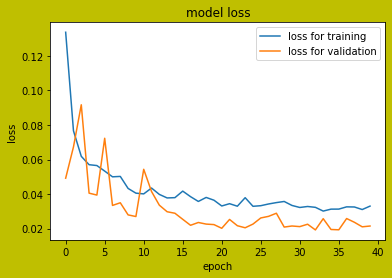

In [ ]:
plot_history_loss(history1)

In [ ]:
#score=modellstm.evaluate(X_test,y_test)
#print(score[0],score[1])

#modellstm.load_weights('./lstmYield_Macro.hdf5')
modellstm.load_weights('drive/My Drive/mae_0.01833_5.592.hdf5')#これ読み込めない。データを変えてしまったから

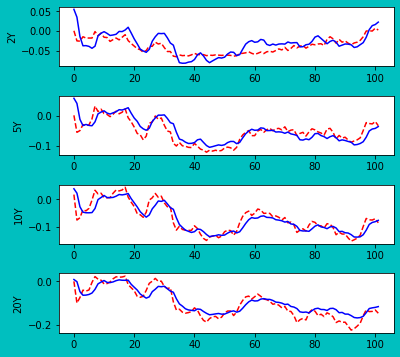

In [ ]:
##個々の利回りの予測をみる。
y_pred = modellstm.predict(X_ntest)

fig = plt.figure(figsize=(6,6),facecolor='c')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(4):
  plt.subplot(4,1,i+1)
  plt.plot(y_ntest[:,i],'r--')#実測値
  plt.plot(y_pred[:,i],'b-')#予測値
  plt.ylabel(bYield.columns[i])

  

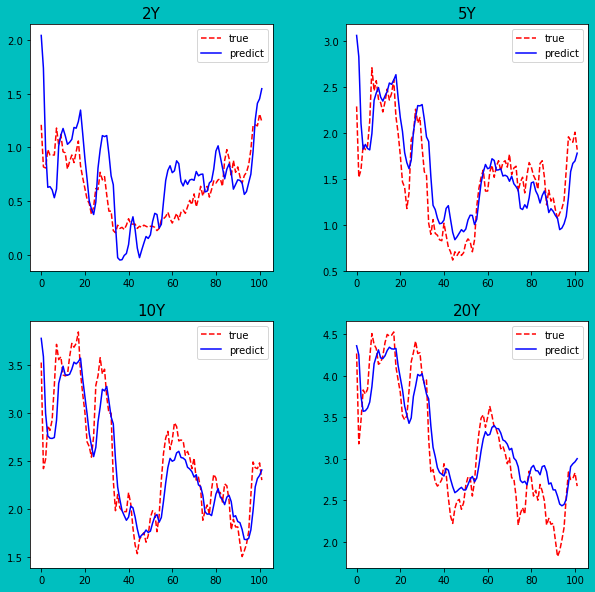

In [ ]:
#実測値に直して考える。
#y_pred = modellstm.predict(X_test)
y_pra = (y_pred)*(Data_train.max().values[23:]-Data_train.min().values[23:])+Data_train.min().values[23:]
y_ts=(y_ntest)*(Data_train.max().values[23:]-Data_train.min().values[23:])+Data_train.min().values[23:]

fig = plt.figure(figsize=(10,10),facecolor='c')
#fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.subplots_adjust(wspace=0.3)
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.plot(y_ts[:,i],'r--',label='true')#実測値
  plt.plot(y_pra[:,i],'b-',label='predict')#予測値
  #plt.ylabel(bYield.columns[i])
  plt.title(bYield.columns[i],fontsize=15)
  plt.legend(loc='best')

  fig.savefig('appendix.png')

In [ ]:
#modellstm.load_weights('drive/My Drive/Mita_thesis/RMSE_0.02206_200_50_20.hdf5')
#y_pred = modellstm.predict(X_test)

#fig = plt.figure(figsize=(6,6),facecolor='m')
#fig.subplots_adjust(hspace=0.5, wspace=0.5)
#for i in range(4):
#  plt.subplot(4,1,i+1)
#  plt.plot(y_test[:,i],'r--')#実測値
#  plt.plot(y_pred[:,i],'b-')#予測値
#  plt.ylabel(bYield.columns[i])

In [ ]:
#実測値に直して考える。
#y_pred = modellstm.predict(X_test)
#y_pra = (y_pred)*(Data_train.max().values[23:]-Data_train.min().values[23:])+Data_train.min().values[23:]
#y_ts=(y_test)*(Data_train.max().values[23:]-Data_train.min().values[23:])+Data_train.min().values[23:]

#fig = plt.figure(figsize=(6,6),facecolor='m')
#fig.subplots_adjust(hspace=0.5, wspace=0.5)
#for i in range(4):
#  plt.subplot(4,1,i+1)
#  plt.plot(y_ts[:,i],'r--')#実測値
#  plt.plot(y_pra[:,i],'b-')#予測値
#  plt.ylabel(bYield.columns[i])

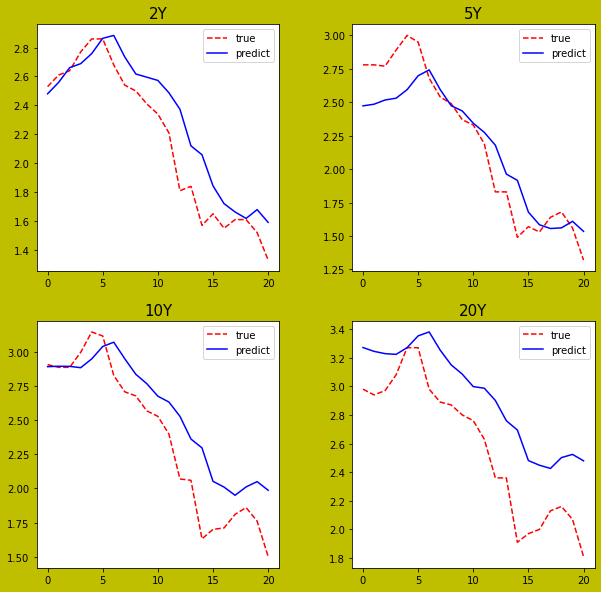

In [ ]:
y_pred = modellstm.predict(X_out)
y_ospra = (y_pred)*(Data_train.max().values[23:]-Data_train.min().values[23:])+Data_train.min().values[23:]
y_osts=(y_out)*(Data_train.max().values[23:]-Data_train.min().values[23:])+Data_train.min().values[23:]

fig = plt.figure(figsize=(10,10),facecolor='y')
#fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.subplots_adjust(wspace=0.3)
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.plot(y_osts[:,i],'r--',label='true')#実測値
  plt.plot(y_ospra[:,i],'b-',label='predict')#予測値
  #plt.ylabel(bYield.columns[i])
  plt.title(bYield.columns[i],fontsize=15)
  plt.legend(loc='best')
plt.show()

fig.savefig('YieldMacro.png')

In [ ]:
r=(y_osts-y_ospra)
rm=r*r
SE=np.sum(rm,axis=1)
MSE=SE / 4.0
RMSE=np.sqrt(MSE)
RMSE,RMSE.sum()

(array([0.21300243, 0.21329586, 0.18113233, 0.20555523, 0.23141831,
        0.13792864, 0.25766988, 0.24074801, 0.17137402, 0.19990272,
        0.18226936, 0.25822712, 0.48597172, 0.29470623, 0.60878685,
        0.32965173, 0.28431018, 0.17111936, 0.19636401, 0.28212162,
        0.44698187]), 5.592537490966128)

In [ ]:
#score=modellstm.evaluate(X_test,y_test)
score = modellstm.evaluate(X_out,y_out)
print(score[0],score[1])

1/1 [==============================] - 0s 2ms/step - loss: 0.0190 - mse: 5.8995e-04
0.019048843532800674 0.0005899484967812896


#### 過去の利回りのみ 1年分でLSTM(さっきまで4でやってた・・・）

#### 結果:マクロ経済変数の有無はそこまで影響しないのか？


In [ ]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset.iloc[i:i+look_back, j]
            xset.append(a)
        dataY.append(dataset.iloc[i+look_back, [0,1,2,3]])      
        dataX.append(xset)
    return np.array(dataX), np.array(dataY)

In [ ]:
bYield=Yield.iloc[:,2:]

#datasetの作成と正規化の処理
#### out of sample 追加 ####
datasplits=int((len(Macro))*0.73)
Data_train1=bYield[:datasplits]
Data_test1=bYield[datasplits:int((len(Macro))*0.93)]
Data_outsample1=bYield[int((len(Macro))*0.93):]
print(Data_train1.shape,Data_test1.shape,Data_outsample1.shape)

#datasetの作成と正規化の処理
#datasplits=int(len(bYield)*0.7)
#Data_train1=bYield[:datasplits]
#Data_test1=bYield[datasplits:]
#print(Data_train1.shape,Data_test1.shape)

#正規化は訓練データのものを使う
Data_train_mm1=(Data_train1-Data_train1.min())/(Data_train1.max()-Data_train1.min())
Data_test_mm1=(Data_test1-Data_train1.min())/(Data_train1.max()-Data_train1.min())
Data_sample_mm1=(Data_outsample1-Data_train1.min())/(Data_train1.max()-Data_train1.min())

(352, 4) (97, 4) (34, 4)


In [ ]:
X_train1,y_train1=create_dataset(Data_train_mm1,12) #lookbackの数は指定したらどうなるか参照
X_test1,y_test1=create_dataset(Data_test_mm1,12)

X_out1,y_out1=create_dataset(Data_sample_mm1,12)

print(X_train1.shape,X_test1.shape,X_out1.shape)

(339, 4, 12) (84, 4, 12) (21, 4, 12)


In [ ]:
#0からmax-1個
#不連続なデータであることの解消
#必要かどうかは考える
Data_mm1=(bYield-Data_train1.min())/(Data_train1.max()-Data_train1.min())
X1,y1=create_dataset(Data_mm1,12)

X_ntest1=np.concatenate((X1[339:352],X_test1),axis=0) #X[315:328] #315は訓練データの数
y_ntest1=np.concatenate((y1[339:352],y_test1),axis=0)

#X[436:449] #436=328+108(検証用データ)間隔は指定した数+1
X_nout1=np.concatenate((X1[436:449],X_out1),axis=0)
y_nout1=np.concatenate((y1[436:449],y_out1),axis=0)

In [ ]:
X_train1=X_train1.reshape(X_train1.shape[0],X_train1.shape[2],X_train1.shape[1])
X_test1=X_test1.reshape(X_test1.shape[0],X_test1.shape[2],X_test1.shape[1])

X_out1=X_out1.reshape(X_out1.shape[0],X_out1.shape[2],X_out1.shape[1])

### 時間不連続を補ったもの ##
X_ntest1=X_ntest1.reshape(X_ntest1.shape[0],X_ntest1.shape[2],X_ntest1.shape[1])

X_nout1=X_nout1.reshape(X_nout1.shape[0],X_nout1.shape[2],X_nout1.shape[1])

In [ ]:
#LSTM
hidden_size=200

#inp=Input(shape=(X_train1.shape[1],X_train1.shape[2]))
inp=Input(shape=(None,X_train1.shape[2]))
lstm=LSTM(units=hidden_size,recurrent_dropout=0.2)(inp)
drop=Dropout(0.2)(lstm)
out=Dense(4,activation='linear')(drop)

modellstm1=Model(inputs=inp,outputs=out)

#modellstm1.compile(optimizer='adam', loss=root_mean_squared_error,metrics=['mse'])
modellstm1.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mse'])
modellstm1.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 4)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               164000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 164,804
Trainable params: 164,804
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mc = ModelCheckpoint(filepath='lstmYield.hdf5', monitor='val_loss', 
                     verbose=1, save_best_only=True, mode='min')

In [ ]:
n_epoch=50
batch_size=20
history2=modellstm1.fit(X_train1,y_train1,callbacks=mc,
                   epochs=n_epoch,validation_data=(X_ntest1,y_ntest1),verbose=0,batch_size=batch_size)


Epoch 00001: val_loss improved from inf to 0.04482, saving model to lstmYield.hdf5

Epoch 00002: val_loss improved from 0.04482 to 0.03969, saving model to lstmYield.hdf5

Epoch 00003: val_loss improved from 0.03969 to 0.03737, saving model to lstmYield.hdf5

Epoch 00004: val_loss improved from 0.03737 to 0.03515, saving model to lstmYield.hdf5

Epoch 00005: val_loss improved from 0.03515 to 0.03213, saving model to lstmYield.hdf5

Epoch 00006: val_loss improved from 0.03213 to 0.03098, saving model to lstmYield.hdf5

Epoch 00007: val_loss improved from 0.03098 to 0.02873, saving model to lstmYield.hdf5

Epoch 00008: val_loss did not improve from 0.02873

Epoch 00009: val_loss did not improve from 0.02873

Epoch 00010: val_loss did not improve from 0.02873

Epoch 00011: val_loss improved from 0.02873 to 0.02830, saving model to lstmYield.hdf5

Epoch 00012: val_loss did not improve from 0.02830

Epoch 00013: val_loss did not improve from 0.02830

Epoch 00014: val_loss improved from 0.0

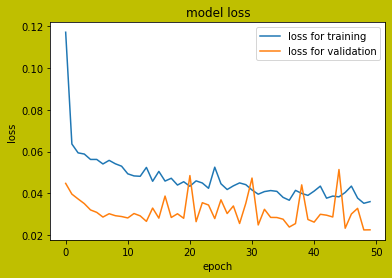

In [ ]:
plot_history_loss(history2)

In [ ]:
#score=modellstm1.evaluate(X_test1,y_test1)
#print(score[0],score[1])

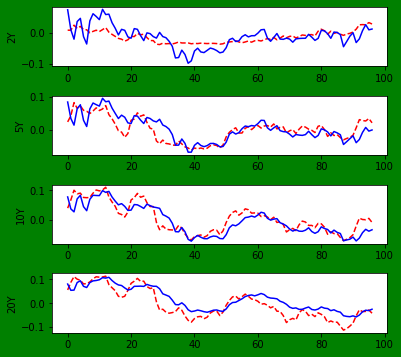

In [ ]:
#modellstm1.load_weights('./lstmYield.hdf5')
modellstm1.load_weights('drive/My Drive/mae_YO_0.02529_6.7629.hdf5')
#modellstm1.load_weights('drive/My Drive/mae_YO_002427_7.21.hdf5')
y_pred1 = modellstm1.predict(X_ntest1)

fig = plt.figure(figsize=(6,6),facecolor='g')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(4):
  plt.subplot(4,1,i+1)
  plt.plot(y_ntest1[:,i],'r--')#実測値
  plt.plot(y_pred1[:,i],'b-')#予測値
  plt.ylabel(bYield.columns[i])

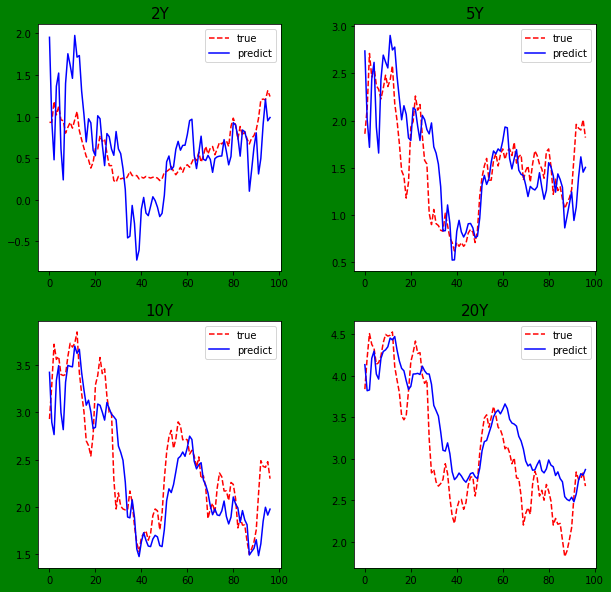

In [ ]:
y_pra1 = (y_pred1)*(Data_train1.max().values-Data_train1.min().values)+Data_train1.min().values
y_ts1=(y_ntest1)*(Data_train1.max().values-Data_train1.min().values)+Data_train1.min().values

fig = plt.figure(figsize=(10,10),facecolor='g')
#fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.subplots_adjust(wspace=0.3)

for i in range(4):
  plt.subplot(2,2,i+1)
  plt.plot(y_ts1[:,i],'r--',label='true')#実測値
  plt.plot(y_pra1[:,i],'b-',label='predict')#予測値
  #plt.ylabel(bYield.columns[i])
  plt.title(bYield.columns[i],fontsize=15)
  plt.legend(loc='best')

fig.savefig('appendix1.png')

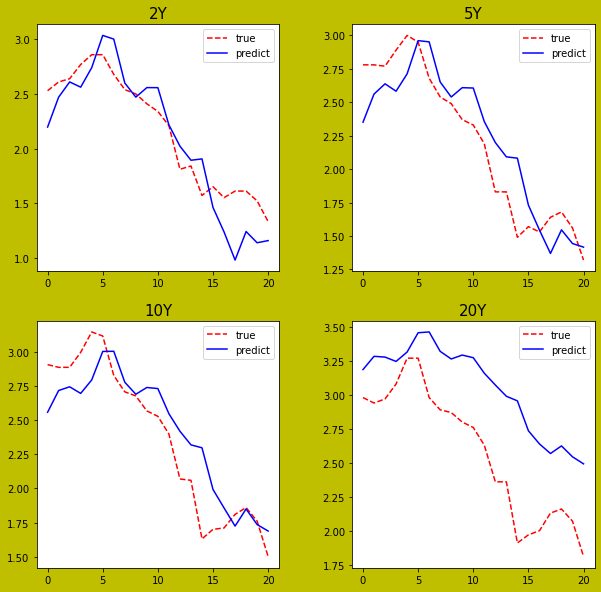

In [ ]:
y_pred = modellstm1.predict(X_out1)
y_ospra1 = (y_pred)*(Data_train1.max().values-Data_train1.min().values)+Data_train1.min().values
y_osts1=(y_out1)*(Data_train1.max().values-Data_train1.min().values)+Data_train1.min().values

fig = plt.figure(figsize=(10,10),facecolor='y')
#fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.subplots_adjust(wspace=0.3)
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.plot(y_osts1[:,i],'r--',label='true')#実測値
  plt.plot(y_ospra1[:,i],'b-',label='predict')#予測値
  #plt.ylabel(bYield.columns[i])
  plt.title(bYield.columns[i],fontsize=15)
  plt.legend(loc='best')
#plt.xlabel(a)
plt.show()

fig.savefig('Yield_only.png')

In [ ]:
r=(y_osts1-y_ospra1)
rm=r*r
SE=np.sum(rm,axis=1)
MSE=SE / 4.0
RMSE=np.sqrt(MSE)
RMSE,RMSE.sum()

(array([0.33912521, 0.23138468, 0.18272915, 0.25290381, 0.23614865,
        0.14068385, 0.33293256, 0.22703819, 0.19926763, 0.29656036,
        0.32759073, 0.2872116 , 0.45060171, 0.36603715, 0.70788988,
        0.42841792, 0.36368053, 0.41001005, 0.30455218, 0.3107117 ,
        0.36750389]), 6.762981414930783)

In [ ]:
#score=modellstm1.evaluate(X_test1,y_test1)
score = modellstm1.evaluate(X_out1,y_out1)
print(score[0],score[1])

1/1 [==============================] - 0s 1ms/step - loss: 0.0210 - mse: 7.2264e-04
0.020952116698026657 0.0007226378656923771


In [ ]:
r=y_ntest1-y_pred1
rm=r*r
RM=np.sum(rm,axis=0) #列つまり債券で総和をとった場合
MSE=RM/y_pred1.shape[0]
#RMSE=math.sqrt(MSE)
#RMSE
MSE,MSE.mean(),np.sqrt(MSE)

(array([0.0007305 , 0.00066415, 0.00071447, 0.00123645]),
 0.000836393241163318,
 array([0.02702782, 0.02577111, 0.02672963, 0.03516314]))

## 最良イールドカーブ比較

In [ ]:
plt.plot(y_ts1[40],'r',label='true')
plt.plot(y_pra1[40],'b',label='predict')
plt.legend(loc='best')
plt.show

#過大評価

In [ ]:
plt.plot(y_ts[40],'r',label='true')
plt.plot(y_pra[40],'b',label='predict')
plt.legend(loc='best')
plt.show

#2年債券だけ過小評価,後は過大評価

In [ ]:
#c=np.sqrt(((y_pra[:,[3]]-y_pra1[:,[3]])**2)/X_train.shape[0])
#c.sum()

### ボツ 重み変更

In [ ]:
#LSTMのoutput4個
hidden_size=100

inp=Input(shape=(X_train.shape[1],X_train.shape[2]))
lstm=LSTM(units=hidden_size,dropout=0.2)(inp)
out1=Dense(1,activation='linear')(lstm)
out2=Dense(1,activation='linear')(lstm)
out3=Dense(1,activation='linear')(lstm)
out4=Dense(1,activation='linear')(lstm)

modellstm_rv=Model(inputs=inp,outputs=[out1,out2,out3,out4])

modellstm_rv.compile(optimizer='adam', loss=['mean_squared_error','mean_squared_error','mean_squared_error','mean_squared_error'],
                  loss_weights=[0.1,0,2,0.3,0.4],
                  metrics=['mean_squared_error'])
modellstm_rv.summary()

In [ ]:
n_epoch=50
batch_size=20
history_rv=modellstm.fit(X_train,y_train,
                   epochs=n_epoch,validation_data=(X_test,y_test),verbose=0,batch_size=batch_size)

In [ ]:
plot_history_loss(history1)

In [ ]:
y_pred = modellstm_rv.predict(X_test)

fig = plt.figure(figsize=(6,6),facecolor='c')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(4):
  plt.subplot(4,1,i+1)
  plt.plot(y_test[:,i],'r--')#実測値
  plt.plot(y_pred[i],'b-')#予測値
  plt.ylabel(bYield.columns[i])